### **Previsão de Trajetória com Corpo Gravitacional usando Redes Neurais**

Esse projeto tem o objetivo de criar um modelo de redes neurais capaz de, dado um cenário bidimensional com:
- Um corpo gravitacional em uma posição ($\alpha$,$\beta$) (m,m) e massa $M$ (kg);
- Uma posição objetivo ($x$,$y$) (m,m) no espaço;

Queremos prever valores de:
- Velocidade ($v$) (m/s);
- Direção ($\theta$) (°);
- Tempo ($t$) (s);

De modo que ao lançar um projétil:
- Partindo da posição ($0$,$0$);
- Com um ângulo $\theta$;
- Com velocidade inicial $v$;

O projétil alcançará a posição ($x$,$y$) no tempo $t$, mesmo sob influência da gravidade do corpo gravitacional.

#### **Seção 0** - Importações

Serão utilizadas nesse modelo as bibliotecas
- PyTorch e NumPy para representar e tratar tensores e vetores;
- MatPlotLib para criar gráficos ilustrando trajetórias;
- Time para registar tempo de treinamento;

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import math

Em seguida, também criamos alguns dicionários determinando parâmetros do nosso modelo de simulação:

In [11]:
# Valores Padrão dos Hiperparâmetros - Modelo de Simulação
DEF_nodes = 96
DEF_minSpeed = 1
DEF_maxSpeed = 20
DEF_minTime = 1
DEF_maxTime = 10
DEF_learningRate = 1e-4
DEF_pointsPerLoss = 1024
DEF_maxRadius = 20
DEF_xBody = 20
DEF_yBody = 20
DEF_attraction = 7500.0
DEF_divisionsPerSimulation = 200
DEF_epochs = 100000
DEF_angle = torch.pi*2

In [12]:
simulated_learner = {
    'identifier': 'simulated_learner',
    'nodes': DEF_nodes,
    'minSpeed': DEF_minSpeed,
    'maxSpeed': DEF_maxSpeed,
    'minTime': DEF_minTime,
    'maxTime': DEF_maxTime,
    'learningRate': DEF_learningRate,
    'pointsPerLoss': DEF_pointsPerLoss,
    'maxRadius': DEF_maxRadius,
    'xBody': DEF_xBody,
    'yBody': DEF_yBody,
    'attraction': DEF_attraction,
    'divisionsPerSimulation': DEF_divisionsPerSimulation,
    'epochs': DEF_epochs,
    'angle': DEF_angle
}

selected_model = simulated_learner

#### **Seção 1** - Classe do Modelo

Essa seção descreve o modelo TripleReluModel utilizado para a rede neural. Nessa classe, serão recebidos os hiperparâmetros `nodes` correspondente ao número de nós por camada, `minSpeed` e `maxSpeed` correspondentes aos valores mínimo e máximo de velocidade considerados e `minTime`, `maxTime` correspondentes ao intervalo de tempo mínimo e máximo aceitáveis.

Esses hiperparâmetros existem tanto para possibilitar fáceis modificações no modelo quanto para evitar casos degenerados que podem levar para pontos problemáticos do espaço paramétrico, incluindo:
- Tempo de alcance excessivamente próximo de zero;
- Tempo de alcance excessivamente grande;
- Velocidade excessivamente próxima de zero;

O modelo é composto pela seguinte estutura de camadas:
- `Input` $\times$ 2 $\rightarrow$ ReLU(`Linear` $\times$ nodes)$^3$ $\rightarrow$ `Output` $\times$ 3

In [13]:
class TripleReluModel(nn.Module):
    def __init__(self, nodes, minSpeed, maxSpeed, minTime, maxTime, angle):
        super().__init__()
        self.minSpeed = minSpeed
        self.maxSpeed = maxSpeed
        self.minTime = minTime
        self.maxTime = maxTime
        self.angle = angle
        self.network = nn.Sequential(
            nn.Linear(2, nodes),
            nn.ReLU(),
            nn.Linear(nodes, nodes),
            nn.ReLU(),
            nn.Linear(nodes, nodes),
            nn.ReLU(),
            nn.Linear(nodes, 3)
        )
        
    def forward(self, xy):
        params = self.network(xy)
        v = self.minSpeed + nn.functional.sigmoid(params[:, 0:1])*(self.maxSpeed - self.minSpeed)
        theta = torch.sigmoid(params[:, 1:2]) * self.angle
        t = self.minTime + torch.sigmoid(params[:, 2:3])*(self.maxTime - self.minTime)
        return v, theta, t

#### **Seção 2** - Classe do Solver

Essa seção descreve a classe principal do projeto, o solver TrajectoryPredictor. O solver que será descrito apresenta os seguintes hiperparâmetros:

- `nodes`, `minSpeed`, `maxSpeed`, `minTime`, `maxTime` usados na classe do modelo;

- `learningRate` descrevendo a taxa de aprendizado utilizada;

- `pointsPerLoss` representando o número de amostras usado em cada cálculo da função de perda;

- `maxRadius` descrevendo o raio máximo em metros em que um ponto objetivo poderá ser gerado longe do centro do corpo gravitacional;

- `xBody`, `yBody` descrevendo a posição do corpo gravitacional no espaço;

- `attraction` representando a massa do corpo gravitacional multiplicada pela constante $G$;

- `divisionsPerSimulation` sendo o número de iterações que uma etapa de simulação contém, onde esse processo é descrito com mais detalhes em um momento mais a frente.

Dados os hiperparâmetros, criamos as funções
- **_ _ init _ _**: Cria o modelo e guarda os valores dos hiperparâmetros. Também inicializa um histórico de perdas, placeholders para a perda e um valor de viés, representando uma constante de suavização para evitar eventuais problemas com distância próxima de zero do corpo gravitacional.

- **show_current_state**: Mostra o estado atual do treino modelo dada a época e percentual de treino já completo.

- **simulate_launch**: Simula uma sequência de lançamentos do objeto nas condições atuais do modelo. Isto é, dados os valores de $v$,$\theta$,$t$ atuais calculados pelo modelo e o ponto objetivo ($x$,$y$), realiza um processo de iterações discretas que aproximam a trajetória real do modelo usando o [Método de Euler Semi-Implicito](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method).

- **calculate_loss**: Gera pontos aleatórios ao redor do corpo gravitacional dentro da distância definida pelo hiperparâmetro, utiliza os pesos atuais da rede neural para simular lançamentos e calcula a perda do modelo, que é calculada como a média do quadrado das distâncias de cada lançamento.

- **fit**: Função que realiza o treinamento do modelo. Para o número definido de épocas, faz seções de treinamento que consistem em um procedimento comum de machine learning, com os detalhes únicos desse modelo sendo o uso de simulações diferenciais para encontrar a perda de uma trajetória.

- **predict**: Função que realiza a predição dos valores desejados dada uma lista de posições do ponto objetivo e retorna uma lista de objetos descrevendo cada predição de forma adequada.

- **get_trajectory**: Retorna os pontos de uma trajetória dados os parâmetros $v$,$\theta$,$t$ utilizados nela.

- **plot_loss**: Faz um gráfico que compara a função de perda ao decorrer das épocas durante a etapa de treinamento.

- **plot_predictions**: Dada uma lista de predições, faz o plot dessas predições, ilustrando a trajetória dos objetos de cada predição.

- **save_state**: Salva o estado treinado do modelo atualmente para evitar múltiplos treinos e preservar resultados.

- **load_state**: Carrega um estado previamente salvo pelo modelo.

- **generate_random_points**: Gera novos pontos aleatórios para etapa de teste.

- **evaluate**: Executa uma etapa de teste do modelo, calculando algumas estatísticas e exibindo plots visuais das predições.

In [14]:
class TrajectoryPredictor:
    def __init__(self, identifier, load = False, nodes = DEF_nodes, minSpeed = DEF_minSpeed, maxSpeed = DEF_maxSpeed, minTime = DEF_minTime, maxTime = DEF_maxTime, learningRate = DEF_learningRate, pointsPerLoss = DEF_pointsPerLoss, maxRadius = DEF_maxRadius, xBody = DEF_xBody, yBody = DEF_yBody, attraction = DEF_attraction, divisionsPerSimulation = DEF_divisionsPerSimulation, epochs = DEF_epochs, angle = DEF_angle):
        
        self.identifier = identifier
        self.nodes = nodes
        self.minSpeed = minSpeed
        self.maxSpeed = maxSpeed
        self.minTime = minTime
        self.maxTime = maxTime
        self.learningRate = learningRate
        self.pointsPerLoss = pointsPerLoss
        self.maxRadius = maxRadius
        self.xBody = xBody
        self.yBody = yBody
        self.attraction = attraction
        self.divisionsPerSimulation = divisionsPerSimulation
        self.epochs = epochs
        self.angle = angle
        
        self.loss = None
        self.lossValue = torch.tensor(0.0)
        self.lossHistory = []
        self.bias = 1
    
        self.model = TripleReluModel(nodes, minSpeed, maxSpeed, minTime, maxTime, angle)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learningRate)
        
        if load:
            load_status = self.load_state() 
            if not load_status.startswith("S"):
                print(f"Falha ao carregar o modelo: {load_status}. Iniciando um novo modelo.")
        
    def show_current_state(self, epoch, percent):
        statusString = f"Epoch: {epoch} ({percent:.1f}%)"
        print(f"{statusString:<25} |   Loss: {self.lossValue.item():.6f}")
        
    def simulate_launch(self, v, th, t, x, y):
        xi = torch.zeros_like(x)
        yi = torch.zeros_like(y)
        dt = t / self.divisionsPerSimulation
        vx = v * torch.cos(th)
        vy = v * torch.sin(th)
        
        for _ in range(self.divisionsPerSimulation):
            rVec_x = self.xBody - xi
            rVec_y = self.yBody - yi
            dist_sq = rVec_x**2 + rVec_y**2 + self.bias
            dist_cubed = dist_sq.pow(1.5)
            
            ax = (self.attraction * rVec_x) / dist_cubed
            ay = (self.attraction * rVec_y) / dist_cubed
            
            vx = vx + ax * dt
            vy = vy + ay * dt
            xi = xi + vx * dt
            yi = yi + vy * dt

        losses_tensor = (xi - x)**2 + (yi - y)**2
        self.loss = torch.mean(losses_tensor)
        self.lossValue = self.loss.detach()
        
    def calculate_loss(self):
        N = self.pointsPerLoss
        alpha = torch.rand(N, 1) * (2 * math.pi)
        r = torch.sqrt(torch.rand(N, 1)) * self.maxRadius
        x_target = self.xBody + r * torch.cos(alpha)
        y_target = self.yBody + r * torch.sin(alpha)
        xy_targets = torch.cat([x_target, y_target], dim=1)
        
        v_pred, th_pred, t_pred = self.model(xy_targets)
        self.simulate_launch(v_pred, th_pred, t_pred, x_target, y_target)
        
    def fit(self, epochs = None, silent = False):
        if epochs is None:
            epochs = self.epochs
            
        self.model.train()
        print(f"Iniciando treino com {epochs} épocas.")
        t0 = time.time()
        
        for epoch in range(1, epochs + 1):
            self.calculate_loss()
            self.optimizer.zero_grad()
            
            if torch.isnan(self.loss):
                continue
            
            self.loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.lossHistory.append(self.lossValue.item())
            
            if (epoch % 500 == 0 or epoch == epochs) and not silent:
                self.show_current_state(epoch,(epoch/epochs)*100)
        
        tn = time.time()
        
        def convert_time(timeSpent):
            total_sec = np.floor(timeSpent)
            total_mins, z = divmod(total_sec, 60)
            x, y = divmod(total_mins, 60)
            
            t1 = "" if x == 0 else f'{x} hora' + ('s ' if x > 1 else ' ')
            t2 = "" if y == 0 else f'{y} minuto' + ('s ' if y > 1 else ' ')
            t3 = "" if z == 0 else f'{z} segundo' + ('s ' if z > 1 else ' ')
            
            return f"{t1}{t2}{t3}"
        
        print(f"Treino finalizado em {convert_time(tn-t0)}.")
        
    def predict(self, x_test):
        self.model.eval()
        x_tensor = torch.tensor(x_test, dtype=torch.float32)
        
        with torch.no_grad():
            v_pred, th_pred, t_final_pred = self.model(x_tensor)
        
        predictions = []
        for i, (xt, yt) in enumerate(x_test):
            predictions.append({
                "target": (xt, yt),
                "v": v_pred[i].item(),
                "theta": th_pred[i].item(),
                "t_final": t_final_pred[i].item()
            })
        return predictions
    
    def get_trajectory(self, v, th, t):
        v = torch.tensor(v, dtype=torch.float32)
        th = torch.tensor(th, dtype=torch.float32)
        t = torch.tensor(t, dtype=torch.float32)

        xi = torch.tensor(0.0)
        yi = torch.tensor(0.0)
        dt = t / self.divisionsPerSimulation
        vx = v * torch.cos(th)
        vy = v * torch.sin(th)
        
        trajectory = np.zeros((self.divisionsPerSimulation + 1, 2))
        trajectory[0] = [xi.item(), yi.item()]
        
        for i in range(self.divisionsPerSimulation):
            r_vec_x = self.xBody - xi
            r_vec_y = self.yBody - yi
            dist_sq = r_vec_x**2 + r_vec_y**2 + self.bias
            dist_cubed = dist_sq.pow(1.5)
            
            ax = (self.attraction * r_vec_x) / dist_cubed
            ay = (self.attraction * r_vec_y) / dist_cubed
            
            vx = vx + ax * dt
            vy = vy + ay * dt
            xi = xi + vx * dt
            yi = yi + vy * dt
            
            trajectory[i+1] = [xi.item(), yi.item()]
            
        return trajectory
    
    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.lossHistory)
        plt.title('Histórico de Perda (Loss) do Treinamento')
        plt.xlabel('Época (Epoch)')
        plt.ylabel('Loss (Log Scale)')
        plt.yscale('log')
        plt.grid(True, which="both", ls="--", alpha=0.5)
        plt.show()
        
    def plot_predictions(self, predictions, silent = True, legend = False):
        plt.figure(figsize=(12, 9))
        num_preds = len(predictions)
        colors = plt.cm.viridis(np.linspace(0, 1, num_preds))
    
        for i, pred in enumerate(predictions):
            target = pred["target"]
            v = pred["v"]
            th = pred["theta"]
            t = pred["t_final"]
            
            if not silent:
                print(f"  Alvo {target}: v={v:.2f}, theta={(th*180/math.pi):.2f}°, t={t:.2f}s")
            
            traj = self.get_trajectory(v, th, t)
            label = f'Alvo {target}'
            
            plt.plot(traj[:, 0], traj[:, 1], color=colors[i], linestyle='-', label=label)
            plt.scatter([target[0]], [target[1]], color=colors[i], s=100, zorder=5, marker='x')

        plt.scatter([0], [0], color='green', s=200, zorder=6, label='Origem')
        plt.scatter([self.xBody], [self.yBody], 
                    color='black', s=400, zorder=6, label='Planeta')
        
        plt.title(f'Previsões do Modelo')
        plt.xlabel('Posição X')
        plt.ylabel('Posição Y')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.axhline(0, color='grey', linewidth=0.5)
        plt.axvline(0, color='grey', linewidth=0.5)
        if legend:
            plt.legend(loc='best')
        plt.axis('equal')
        plt.show()
        
    def save_state(self):
        filepath = f'./models/gravitational/{self.identifier}.pth'
        
        state = state = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss_history': self.lossHistory,

            'identifier': self.identifier,
            'nodes': self.nodes,
            'minSpeed': self.minSpeed,
            'maxSpeed': self.maxSpeed,
            'minTime': self.minTime,
            'maxTime': self.maxTime,
            'learningRate': self.learningRate,
            'pointsPerLoss': self.pointsPerLoss,
            'maxRadius': self.maxRadius,
            'xBody': self.xBody,
            'yBody': self.yBody,
            'attraction': self.attraction,
            'divisionsPerSimulation': self.divisionsPerSimulation,
            'epochs': self.epochs,
            'angle': self.angle
        }
        
        torch.save(state, filepath)
        print(f"Modelo {self.identifier} salvo com sucesso em: '{filepath}'")

    def load_state(self):
        try:
            filepath = f'./models/gravitational/{self.identifier}.pth'
            savepoint = torch.load(filepath)
            savepoint['angle'] = self.angle
            
            self.model.load_state_dict(savepoint['model_state_dict'])
            self.optimizer.load_state_dict(savepoint['optimizer_state_dict'])
            self.lossHistory = savepoint['loss_history']
            
            self.nodes = savepoint['nodes']
            self.minSpeed = savepoint['minSpeed']
            self.maxSpeed = savepoint['maxSpeed']
            self.minTime = savepoint['minTime']
            self.maxTime = savepoint['maxTime']
            self.learningRate = savepoint['learningRate']
            self.pointsPerLoss = savepoint['pointsPerLoss']
            self.maxRadius = savepoint['maxRadius']
            self.xBody = savepoint['xBody']
            self.yBody = savepoint['yBody']
            self.attraction = savepoint['attraction']
            self.divisionsPerSimulation = savepoint['divisionsPerSimulation']
            self.epochs = savepoint['epochs']
            self.angle = savepoint['angle']
            
            self.model.eval()
            
            print(f"Modelo {self.identifier} carregado com sucesso de: '{filepath}'")
            if self.lossHistory:
                self.lossValue = torch.tensor(self.lossHistory[-1])
            return "S"
        except FileNotFoundError:
            return "N-File Not Found"
        except Exception as e:
            return f"E-{e}"
        
    def generate_random_points(self, N):
        alpha = np.random.rand(N, 1) * (2 * math.pi)
        r = np.sqrt(np.random.rand(N, 1)) * self.maxRadius
        x_target = self.xBody + r * np.cos(alpha)
        y_target = self.yBody + r * np.sin(alpha)
        return np.hstack([x_target, y_target])

    def evaluate(self, N):
        x_k = self.generate_random_points(N)
        preds = self.predict(x_k)
        self.plot_predictions(preds)

        all_errors = []
        for pred in preds:
            v = pred["v"]
            th = pred["theta"]
            t = pred["t_final"]
            target_pos = pred["target"]

            traj = self.get_trajectory(v, th, t)
            final_pos = traj[-1]
            
            error_dist = np.sqrt((final_pos[0] - target_pos[0])**2 + (final_pos[1] - target_pos[1])**2)
            all_errors.append(error_dist)
            
        errors_np = np.array(all_errors)
        mse = np.mean(np.square(errors_np))
        mean_error = np.mean(errors_np)
        min_error = np.min(errors_np)
        max_error = np.max(errors_np)
        median_error = np.median(errors_np)

        print(f"Erro Quadrático Médio (MSE): {mse:.4f}")
        print(f"Erro Médio:                 {mean_error:.4f}")
        print(f"Erro Mediano:               {median_error:.4f}")
        print(f"Erro Mínimo:                {min_error:.4f}")
        print(f"Erro Máximo:                {max_error:.4f}")

#### **Seção 3** - Treinamento

Nessa seção, criaremos uma instância simples do problema e o treinaremos. Nosso cenário consiste de um planeta em ($20$,$20$) com força de atração de 7500, onde os pontos objetivo estão distribuídos a um raio de 20 $m$ dele. Treinaremos usando uma instância com 96 nós por camada, taxa de treinamento de $10^{-4}$, 200 divisões por simulação e 1024 pontos por cálculo da função de perda. Precisamos lançar um objeto de modo que ele acerte o seu alvo sem restrições quanto a direção, mas com uma velocidade mínima de 1 $m/s$ e máxima de 20 $m/s$ em um tempo de 1 até 10 $s$.

In [15]:
solver = TrajectoryPredictor(
    identifier = selected_model['identifier'],
    nodes = selected_model['nodes'],
    minSpeed = selected_model['minSpeed'],
    maxSpeed = selected_model['maxSpeed'],
    minTime = selected_model['minTime'],
    maxTime = selected_model['maxTime'],
    learningRate = selected_model['learningRate'],
    pointsPerLoss = selected_model['pointsPerLoss'],
    maxRadius = selected_model['maxRadius'],
    xBody = selected_model['xBody'],
    yBody = selected_model['yBody'],
    attraction = selected_model['attraction'],
    divisionsPerSimulation = selected_model['divisionsPerSimulation'],
    epochs = selected_model['epochs']
)

Agora, executamos o treinamento, se já não estiver salvo.

In [16]:
tryLoad = solver.load_state()
if tryLoad[0] != 'S':
    solver.fit()

Modelo simulated_learner carregado com sucesso de: './models/gravitational/simulated_learner.pth'


#### **Seção 4** - Avaliação

Por fim, faremos uma avaliação rápida do nosso modelo, para entender se ele se aproximou bem o bastante dos pontos novos propostos. Geraremos 60 pontos novos dentro do mesmo raio do hiperparâmetro e chamaremos a função de predição e plotagem com esses pontos. Também calcularemos estatísticas do nosso erro, como MSE, erro mínimo, erro máximo e mediana dos erros para entender melhor sua distribuição.

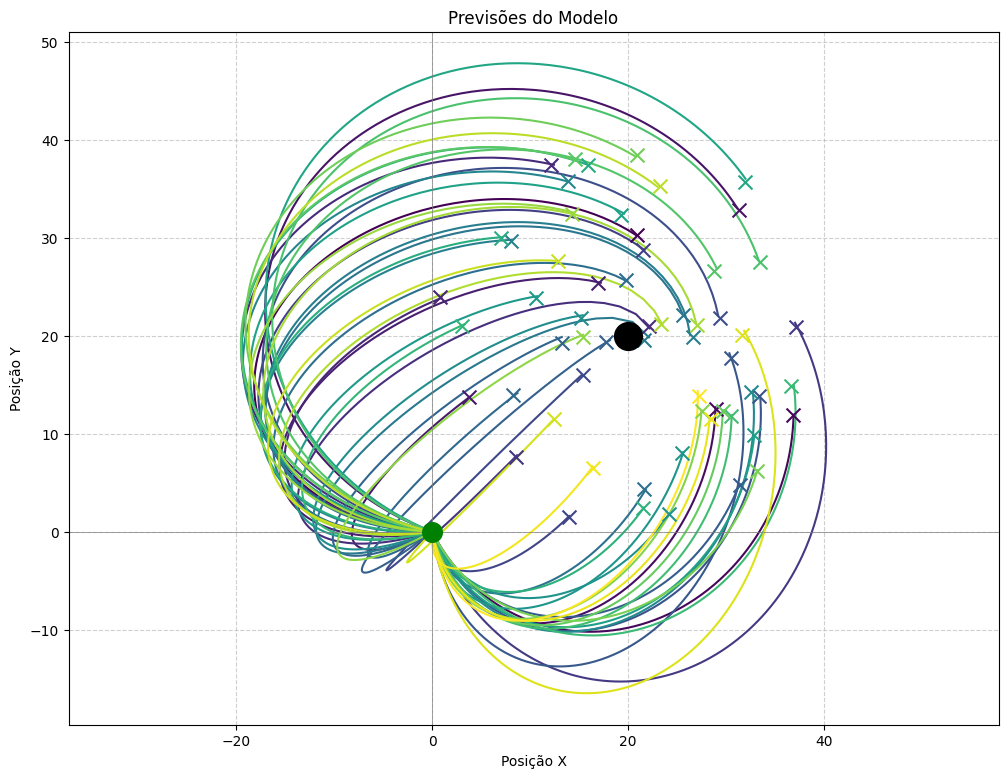

Erro Quadrático Médio (MSE): 0.0712
Erro Médio:                 0.2236
Erro Mediano:               0.1862
Erro Mínimo:                0.0050
Erro Máximo:                0.5880


In [17]:
solver.evaluate(60)

Por fim, podemos salvar nossos resultados na ocasião de termos treinado um novo modelo:

In [18]:
if tryLoad[0] != 'S':
    solver.save_state()